## Notebook 2: Análisis Exploratorio y Filtrado de Datos

**Objetivo:** Cargar los datos consolidados, aplicar los filtros para generar los subconjuntos de datos (para 'cantidad' y 'monto_venta') y guardarlos en subcarpetas separadas.

**Fases:**
1.  **Configuración:** Importar librerías y funciones de `utils`.
2.  **Carga de Datos Consolidados:** Cargar `ventas_mensuales_consolidadas.csv`.
3.  **Análisis Exploratorio (EDA):** Graficar la serie de tiempo total de ventas en unidades.
4.  **Generación de Subconjuntos:** Aplicar filtros para ambas vertientes (unidades y guaraníes).
5.  **Guardado:** Exportar cada subconjunto a sus respectivas carpetas.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ### 1. Configuración
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

from utils.utils import filtrar_outliers_iqr, filtrar_por_relevancia, filtrar_por_volumen_y_dispersion

# --- Definición de Rutas Relativas ---
PROCESSED_DATA_DIR = '../02_Data/02_processed/'
FIGURES_DIR = '../04_Resultados/02_Figuras/'

os.makedirs(FIGURES_DIR, exist_ok=True)

print("Librerías y módulos importados. Rutas definidas.")

Librerías y módulos importados. Rutas definidas.


In [3]:
# ### 2. Carga de Datos Consolidados
try:
    df_mensual = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'ventas_mensuales_consolidadas.csv'), parse_dates=['mes'])
    print("Datos mensuales consolidados cargados correctamente.")
    print(f"Dimensiones: {df_mensual.shape}")
except FileNotFoundError:
    print("Error: El archivo 'ventas_mensuales_consolidadas.csv' no fue encontrado.")
    print("Por favor, asegúrate de haber ejecutado el notebook '01_Preprocesamiento.ipynb' primero.")

Datos mensuales consolidados cargados correctamente.
Dimensiones: (248710, 6)


C:\Users\isaia\AppData\Local\Temp\ipykernel_33092\3770961611.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mensual = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'ventas_mensuales_consolidadas.csv'), parse_dates=['mes'])



Generando gráficos de ventas totales mensuales (Unidades y Guaraníes)...
Gráfico 'cantidad' guardado en: ../04_Resultados/02_Figuras/serie_temporal_ventas_unidades.png


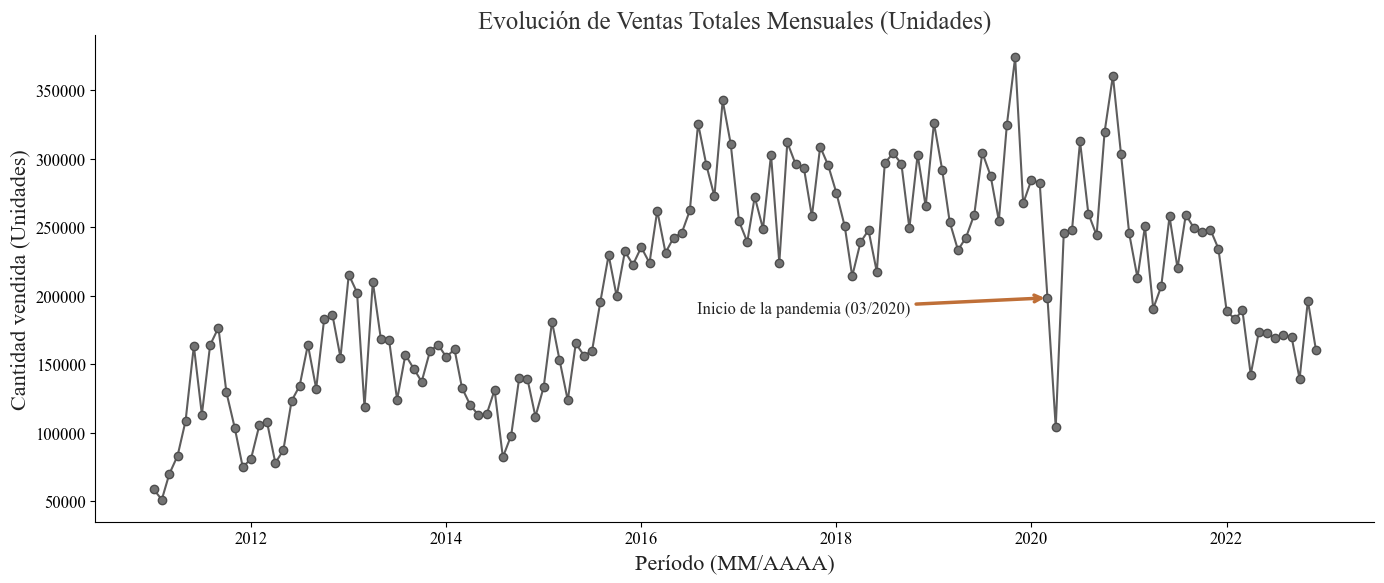

Gráfico 'monto_venta' guardado en: ../04_Resultados/02_Figuras/serie_temporal_ventas_guaranies.png


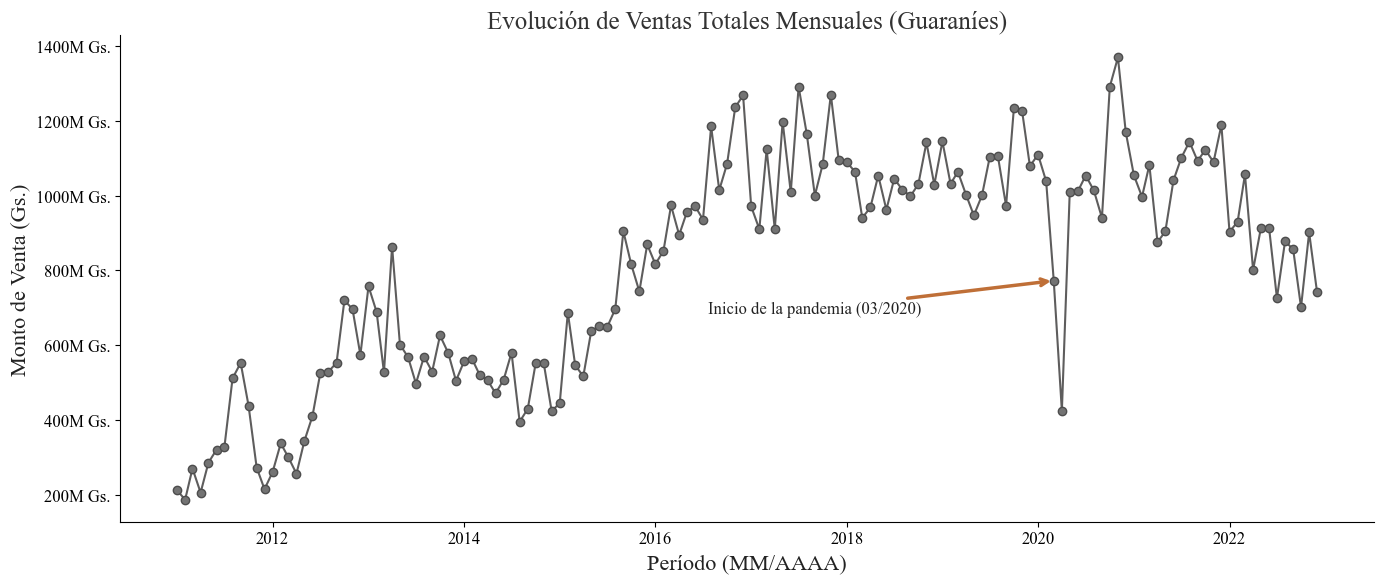

In [4]:
# ### 3. Análisis Exploratorio (EDA)
# Generación de gráficos de serie temporal para ambas vertientes: Unidades y Guaraníes.
import matplotlib.ticker as mticker

print("\nGenerando gráficos de ventas totales mensuales (Unidades y Guaraníes)...")

if 'df_mensual' in locals():
    
    metricas_a_graficar = {
        'cantidad': {
            'titulo': 'Evolución de Ventas Totales Mensuales (Unidades)',
            'ylabel': 'Cantidad vendida (Unidades)',
            'filename': 'serie_temporal_ventas_unidades'
        },
        'monto_venta': {
            'titulo': 'Evolución de Ventas Totales Mensuales (Guaraníes)',
            'ylabel': 'Monto de Venta (Gs.)',
            'filename': 'serie_temporal_ventas_guaranies'
        }
    }

    for metrica, config in metricas_a_graficar.items():
        
        ventas_por_mes = df_mensual.groupby('mes')[metrica].sum()
        
        # Replicar el estilo del gráfico del paper
        plt.rcParams.update({"font.family": "serif", "font.serif": ["Times New Roman"], "font.size": 12})
        fig, ax = plt.subplots(figsize=(14, 6))
        
        ax.plot(ventas_por_mes.index, ventas_por_mes.values, marker='o', linestyle='-', color="#5e5d5d", markerfacecolor='#737373', markeredgewidth=1, markeredgecolor='#4d4d4d')
        
        ax.set_title(config['titulo'], fontsize=18, color='#333333')
        ax.set_xlabel("Período (MM/AAAA)", fontsize=16, color='#222222')
        ax.set_ylabel(config['ylabel'], fontsize=16, color='#222222')
        ax.grid(False)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Formateador para el eje Y en caso de ser monto_venta
        if metrica == 'monto_venta':
            def millions_formatter(x, pos):
                return f'{int(x/1e6)}M Gs.'
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
        
        # Anotación de la pandemia
        marzo_2020 = pd.Timestamp('2020-03')
        if marzo_2020 in ventas_por_mes.index:
            ax.annotate('Inicio de la pandemia (03/2020)', 
                         xy=(marzo_2020, ventas_por_mes.loc[marzo_2020]), 
                         xytext=(marzo_2020 - pd.DateOffset(months=30), ventas_por_mes.max() * 0.5),
                         arrowprops=dict(color="#bf6f37", arrowstyle='->', linewidth=2.5), 
                         color='#222222', 
                         fontsize=12,
                         ha='center')
                         
        plt.tight_layout()
        
        # Guardar en múltiples formatos
        fig_path_eps = os.path.join(FIGURES_DIR, f"{config['filename']}.eps")
        fig_path_png = os.path.join(FIGURES_DIR, f"{config['filename']}.png")
        plt.savefig(fig_path_eps, format='eps')
        plt.savefig(fig_path_png, format='png', dpi=300)
        print(f"Gráfico '{metrica}' guardado en: {fig_path_png}")
        
        plt.show()

In [5]:
# ### 4. Generación de Subconjuntos para Ambas Vertientes (REFACTORIZADO)

if 'df_mensual' in locals():
    
    # --- 1. Definiciones Base (Fuera del Bucle) ---
    targets = ['cantidad', 'monto_venta']
    corte_pandemia = pd.to_datetime('2020-02-01')

    # --- 2. Preparar DFs Base (Fuera del Bucle) ---
    # Estos son los DFs "Naturales" (sin filtro IQR)
    
    logging.info("Creando DFs base (Total y 48 Meses)...")
    
    # N_P: Natural, Con Pandemia (Todo el historial)
    df_N_P_base = df_mensual.copy()
    
    # N_NP: Natural, Sin Pandemia (Todo el historial hasta el corte)
    df_N_NP_base = df_mensual[df_mensual['mes'] <= corte_pandemia].copy()

    # N_48_P: Natural, 48 Meses, Con Pandemia
    # (Paso A: Seleccionar los 4 años usando tu función original)
    df_N_48_P_base = filtrar_por_relevancia(df_N_P_base, n_anios=4)
    
    # (Paso B: Aplicar nuestro NUEVO filtro de volumen/dispersión)
    logging.info("Aplicando filtro de volumen/dispersión a la ventana de 48 meses...")
    df_N_48_P_base = filtrar_por_volumen_y_dispersion(
        df_N_48_P_base,
        col_producto='codigo_producto',
        col_fecha='mes',
        col_valor='cantidad', # Usamos 'cantidad' para definir relevancia
        min_meses_venta=12,
        quantile_filtro=0.25
    )
    
    # N_48_NP: Natural, 48 Meses, Sin Pandemia
    # (Se crea a partir del DF anterior, que ya tiene AMBOS filtros de relevancia)
    df_N_48_NP_base = df_N_48_P_base[df_N_48_P_base['mes'] <= corte_pandemia].copy()
    
    # --- 3. Bucle por Target (Para aplicar filtros IQR) ---
    # Este bucle ahora es más rápido, solo aplica el filtro de outliers.
    
    for target in targets:
        print(f"\n--- PROCESANDO PARA TARGET: {target.upper()} ---")
        
        # Crear subdirectorio si no existe
        output_subdir = os.path.join(PROCESSED_DATA_DIR, target)
        os.makedirs(output_subdir, exist_ok=True)
        
        logging.info(f"Generando datasets filtrados (IQR) para '{target}'...")
        
        # --- DFs Naturales (ya los tenemos) ---
        df_N_P = df_N_P_base.copy()
        df_N_NP = df_N_NP_base.copy()
        df_N_48_P = df_N_48_P_base.copy()
        df_N_48_NP = df_N_48_NP_base.copy()

        # --- DFs Filtrados (aplicar filtro IQR) ---
        # El filtro IQR SÍ depende del target, por eso va DENTRO del bucle.
        
        df_F_P = filtrar_outliers_iqr(df_N_P, value_col=target, group_by_col='codigo_producto')
        df_F_NP = filtrar_outliers_iqr(df_N_NP, value_col=target, group_by_col='codigo_producto')
        df_F_48_P = filtrar_outliers_iqr(df_N_48_P, value_col=target, group_by_col='codigo_producto')
        df_F_48_NP = filtrar_outliers_iqr(df_N_48_NP, value_col=target, group_by_col='codigo_producto')

        datasets = {
            "N_P": df_N_P, "N_NP": df_N_NP,
            "N_48_P": df_N_48_P, "N_48_NP": df_N_48_NP,
            "F_P": df_F_P, "F_NP": df_F_NP,
            "F_48_P": df_F_48_P, "F_48_NP": df_F_48_NP
        }
        
        print(f"\nGuardando subconjuntos para '{target}' en: {output_subdir}")
        for name, df in datasets.items():
            if not df.empty:
                output_path = os.path.join(output_subdir, f'ventas_{name}.csv')
                df.to_csv(output_path, index=False)
                print(f" -> Guardado: {output_path} (Dimensiones: {df.shape})")
            else:
                print(f" -> Omitido: {name} está vacío.")

    print("\n¡Pipeline de análisis y filtrado completado para ambas vertientes!")
else:
    print("\nNo se ejecutó el pipeline de filtrado porque el DataFrame 'df_mensual' no se cargó.")

2025-11-07 10:15:14,888 - INFO - Creando DFs base (Total y 48 Meses)...
2025-11-07 10:15:14,948 - INFO - Aplicando filtro de volumen/dispersión a la ventana de 48 meses...
2025-11-07 10:15:15,007 - INFO - Generando datasets filtrados (IQR) para 'cantidad'...


Filtrando por relevancia: 2919 productos vendidos en cada uno de los últimos 4 años.
¡Filtro de volumen y dispersión completado! Productos reducidos de 2919 a 2115.

--- PROCESANDO PARA TARGET: CANTIDAD ---
Filtro IQR (por producto) aplicado a 'cantidad'. Se eliminaron 14180 filas.
Filtro IQR (por producto) aplicado a 'cantidad'. Se eliminaron 10178 filas.
Filtro IQR (por producto) aplicado a 'cantidad'. Se eliminaron 6794 filas.
Filtro IQR (por producto) aplicado a 'cantidad'. Se eliminaron 4318 filas.

Guardando subconjuntos para 'cantidad' en: ../02_Data/02_processed/cantidad
 -> Guardado: ../02_Data/02_processed/cantidad\ventas_N_P.csv (Dimensiones: (248710, 6))
 -> Guardado: ../02_Data/02_processed/cantidad\ventas_N_NP.csv (Dimensiones: (178293, 6))
 -> Guardado: ../02_Data/02_processed/cantidad\ventas_N_48_P.csv (Dimensiones: (130188, 6))
 -> Guardado: ../02_Data/02_processed/cantidad\ventas_N_48_NP.csv (Dimensiones: (82913, 6))
 -> Guardado: ../02_Data/02_processed/cantidad\vent

2025-11-07 10:15:18,368 - INFO - Generando datasets filtrados (IQR) para 'monto_venta'...


 -> Guardado: ../02_Data/02_processed/cantidad\ventas_F_48_P.csv (Dimensiones: (123394, 6))
 -> Guardado: ../02_Data/02_processed/cantidad\ventas_F_48_NP.csv (Dimensiones: (78595, 6))

--- PROCESANDO PARA TARGET: MONTO_VENTA ---
Filtro IQR (por producto) aplicado a 'monto_venta'. Se eliminaron 13799 filas.
Filtro IQR (por producto) aplicado a 'monto_venta'. Se eliminaron 9996 filas.
Filtro IQR (por producto) aplicado a 'monto_venta'. Se eliminaron 6396 filas.
Filtro IQR (por producto) aplicado a 'monto_venta'. Se eliminaron 4061 filas.

Guardando subconjuntos para 'monto_venta' en: ../02_Data/02_processed/monto_venta
 -> Guardado: ../02_Data/02_processed/monto_venta\ventas_N_P.csv (Dimensiones: (248710, 6))
 -> Guardado: ../02_Data/02_processed/monto_venta\ventas_N_NP.csv (Dimensiones: (178293, 6))
 -> Guardado: ../02_Data/02_processed/monto_venta\ventas_N_48_P.csv (Dimensiones: (130188, 6))
 -> Guardado: ../02_Data/02_processed/monto_venta\ventas_N_48_NP.csv (Dimensiones: (82913, 6))
